# Monitoring the model stability
Plot the location of the maximum vertical velocity (w_bt) and its time seriers.

In [130]:
# import modules
%matplotlib inline

import cosima_cookbook as cc

import matplotlib.pyplot as plt
import matplotlib.cm as cm # colormap
import numpy as np
import netCDF4 as nc
import re # extract string
import glob # join multi files
import os
import datetime

import xarray as xr
import pandas as pd

Read in the ocean grid

In [2]:
datadir = '/g/data3/hh5/tmp/cosima/'
configuration = 'mom01v5'
expt = 'KDS75_newbathy_JRA'
file_obs_path = os.path.join(datadir, configuration, expt, 'output000/ocean.nc')
file_obs = xr.open_dataset(file_obs_path, decode_times=False)

MOM creates a log file called `mom.out`. This file contains lines of the form:

` w_bt ( 0.919E-02 m/s) is   29.84 % of CFL ( 0.308E-01 m/s) at (i,j,k) = (2042,1434, 15), (lon,lat,dpt) = (     -75.850,      18.519,    35.849 m)\n'`

which give the maximum vertical velocity and its location. A few (not always the same number) of lines later down is the time from that observation of maximum w_bt.

`yyyy/mm/dd hh:mm:ss =    1/ 2/ 3  0: 0: 0`

We need to extract both of these values


In [235]:
def read_w_bt_from_mom_out(mom_out_filename):
    "Reads in a given mom.out file and returns the maximum w_bt information"

    w_bt_pattern = 'w_bt \((.*) m/s\) is (.*) % of CFL (.*) at (.*) \(lon,lat,dpt\) = \((.*)m\)'
    w_bt_regex = re.compile(w_bt_pattern)
    
    ymd_pattern = 'yyyy/mm/dd hh:mm:ss = (.*)'
    ymd_regex = re.compile(ymd_pattern)

    w_bt_list = []
    with open(mom_out_filename) as f:
    
        reader = iter(f.readlines())
    
        for line in reader:
        
            m = w_bt_regex.search(line)
            if m is None:
                continue
            w_bt = dict()
            
            w_bt['w_bt'] = float(m.group(1))
            w_bt['percent_CFL'] = float(m.group(2))/100
            
            location = [float(x) for x in m.group(5).split(',')]
            w_bt['lon'] = location[0]
            w_bt['lat'] = location[1]
            w_bt['depth'] = location[2]

            for line in reader:
                m = ymd_regex.search(line)
                if m is not None:
                    
                    ymd = m.group(1)
                    ymd = ymd.replace('/', ' ').replace(':', ' ')
                    ymd = ymd.split()
                    ymd = [int(x) for x in ymd]
                    w_bt['datetime'] = datetime.datetime(1900+ymd[0],
                                                        ymd[1],
                                                        ymd[2])
                    break
            w_bt_list.append(w_bt)
    return w_bt_list

In [178]:
mom_out_file_pattern = os.path.join(datadir, configuration, expt, 'output*/mom.out')
mom_out_files = sorted(glob.glob(mom_out_file_pattern))

In [179]:
w_bt_list = []
for mom_out_filename in mom_out_files:
    w_bt_list.extend(read_w_bt_from_mom_out(mom_out_filename))

We construct a pandas DataFrame of the max `w_bt` observations from the output logs.

In [228]:
w_bt_df = pd.DataFrame(w_bt_list)
index = pd.DatetimeIndex(w_bt_df.datetime)
w_bt_df = w_bt_df.set_index(index)
w_bt_df['days'] = (w_bt_df['datetime'] - datetime.datetime(1901,1,1)).astype(int) / 864e11
w_bt_df.head()

,datetime,depth,lat,lon,percent_CFL,w_bt,days
datetime,,,,,,,
1901-01-02,1901-01-02,35.849,18.519,-75.850,0.2984,0.00919,1.0
1901-01-03,1901-01-03,27.327,73.939,-90.051,0.1553,-0.00389,2.0
1901-01-04,1901-01-04,31.299,66.094,-84.673,0.1718,-0.00476,3.0
1901-01-05,1901-01-05,27.322,66.081,-84.668,0.1597,-0.00400,4.0
1901-01-06,1901-01-06,12.253,-71.478,-189.350,0.1247,0.00185,5.0


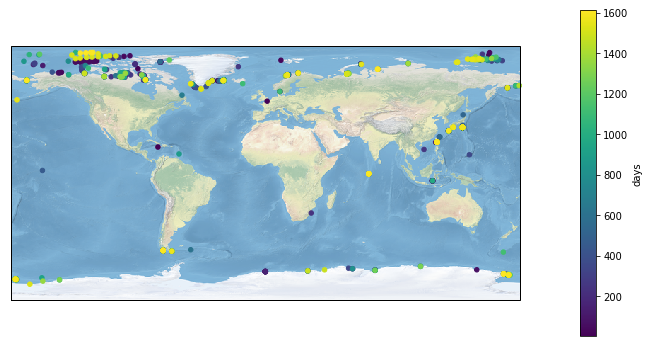

In [232]:
import cartopy.crs as ccrs

plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

w_bt_df.plot.scatter(x='lon', y='lat', c='days', 
                     cmap=plt.cm.viridis, ax=ax)

(0, 1)

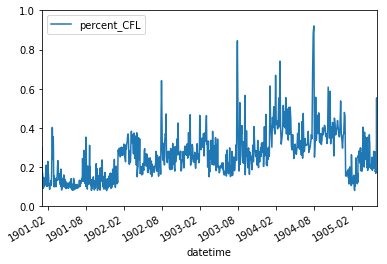

In [234]:
w_bt_df.plot(y='percent_CFL')
plt.ylim(0,1)